<a href="https://colab.research.google.com/github/Baronco/Deep-Learning-models/blob/main/California_Housing_Regression_model_with_Multi_layer_Perceptrons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout,BatchNormalization,Conv1D,MaxPooling1D,Flatten, concatenate


import plotly.express as px
import plotly.graph_objects as go


print(tf.__version__)

2.15.0


# Training data

In [2]:
train_data = pd.read_csv('/content/sample_data/california_housing_train.csv')

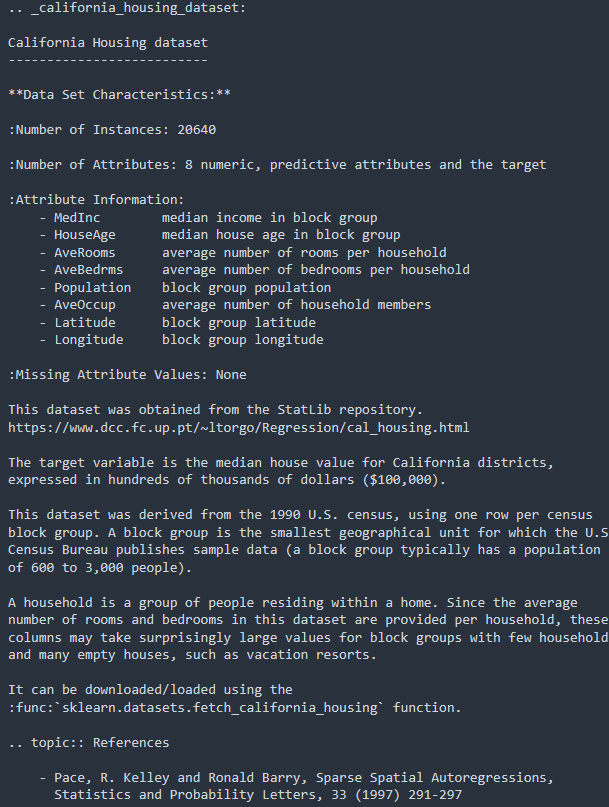

# Exploratory Data Analysis (EDA)

these data do not have null values

In [3]:
print(f'Data training shape: {train_data.shape}')

Data training shape: (17000, 9)


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [5]:
# rename the target column
train_data.rename(columns={'median_house_value':'y'}, inplace=True)
# Data is scaled by 100,000
train_data['y'] = train_data['y']/100000

In [6]:
train_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,y
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,0.669
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,0.801
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,0.857
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,0.734
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,0.655


## Pair Plot and correlation plot

Reviewing the spearman correlation of the regressors and target variable, the regressors that could have a possible statistical significance with the median house price would be "housing_median_age", "median_income" and "total_rooms".

 "housing_median_age and "total_rooms" has a strong autoccorelation, this is problematic for diagnostic analytics, in this case my goal is predictive analytics.

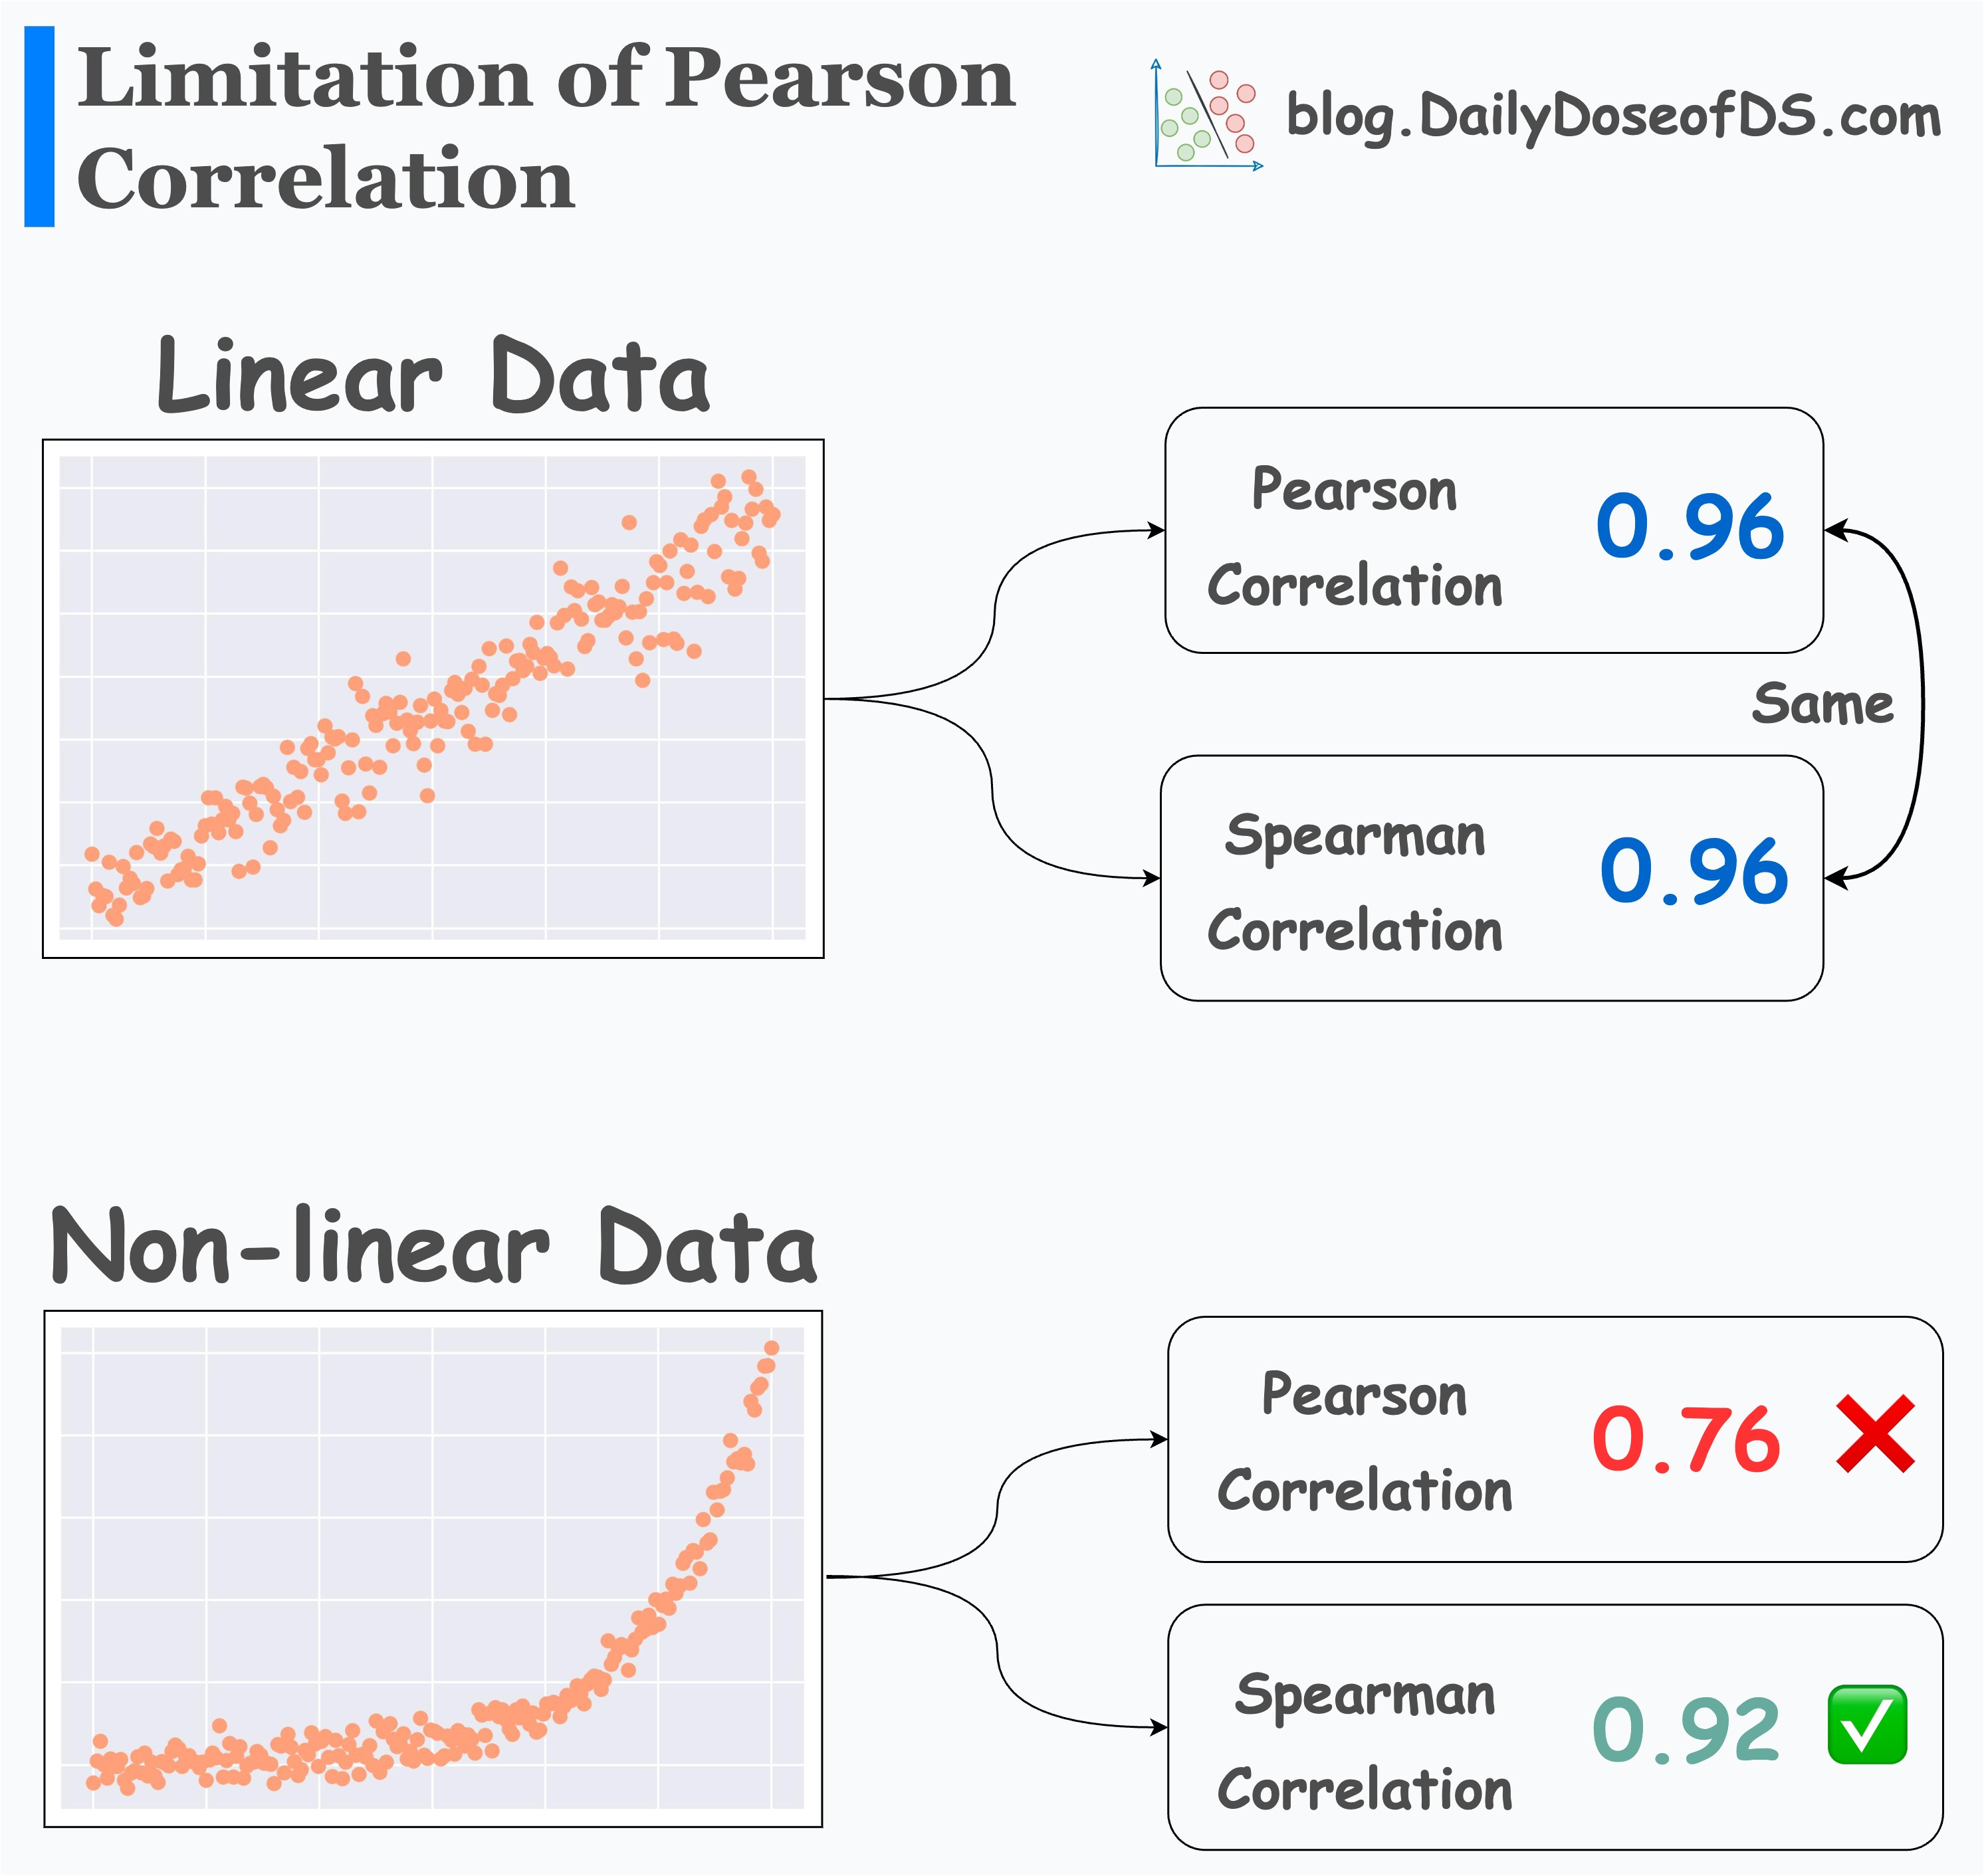

In [7]:
cols = ['households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'total_bedrooms',
       'total_rooms','y']

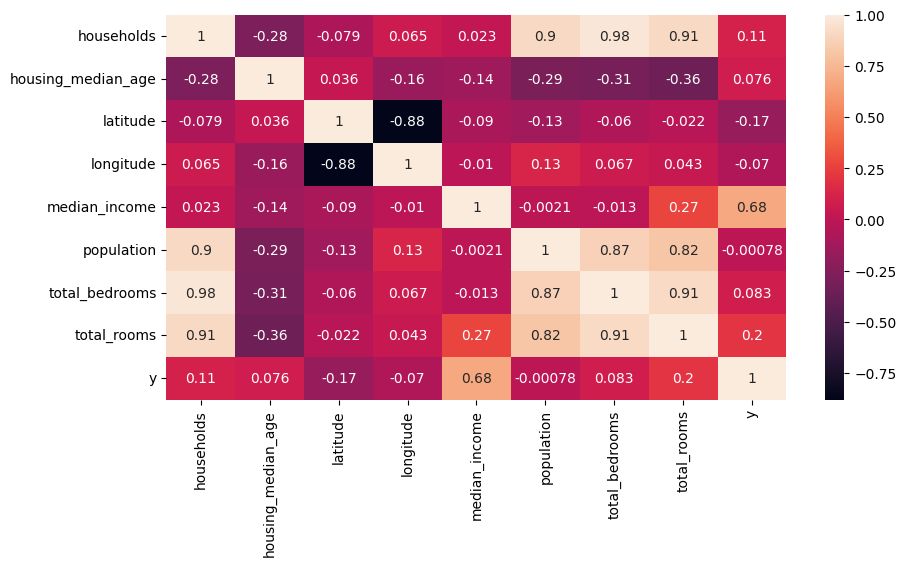

In [8]:
plt.figure(figsize= (10, 5))
sns.heatmap(train_data[cols].corr(method='spearman'), annot=True)
plt.show()

In [9]:
features = ['households','median_income','total_rooms','y']

<Figure size 600x600 with 0 Axes>

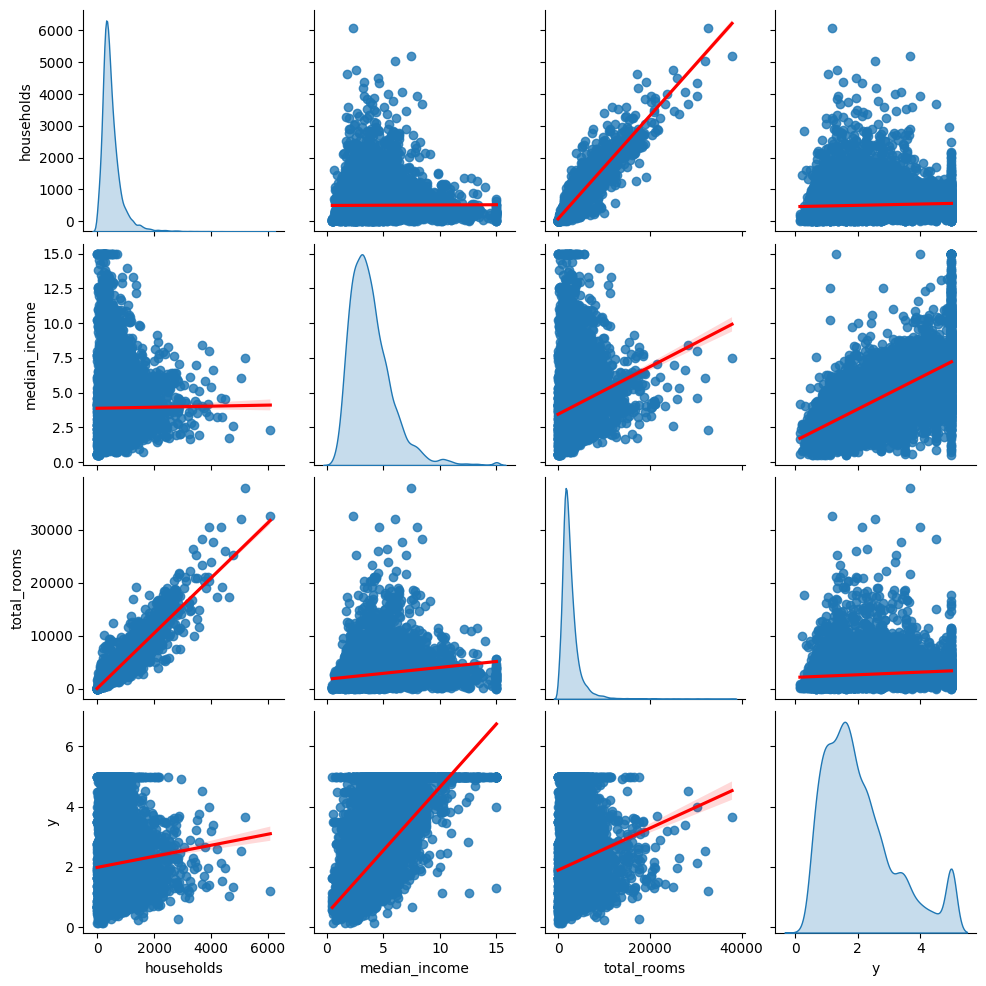

In [10]:

plt.figure(figsize=(6, 6))
sns.pairplot(
    train_data[features],
    diag_kind='kde',
    kind="reg", plot_kws={'line_kws':{'color':'red'}}
)
plt.show()

## Histplot and boxplots

The distribution of the regressors and the target variable shows positive skewness and outliers.


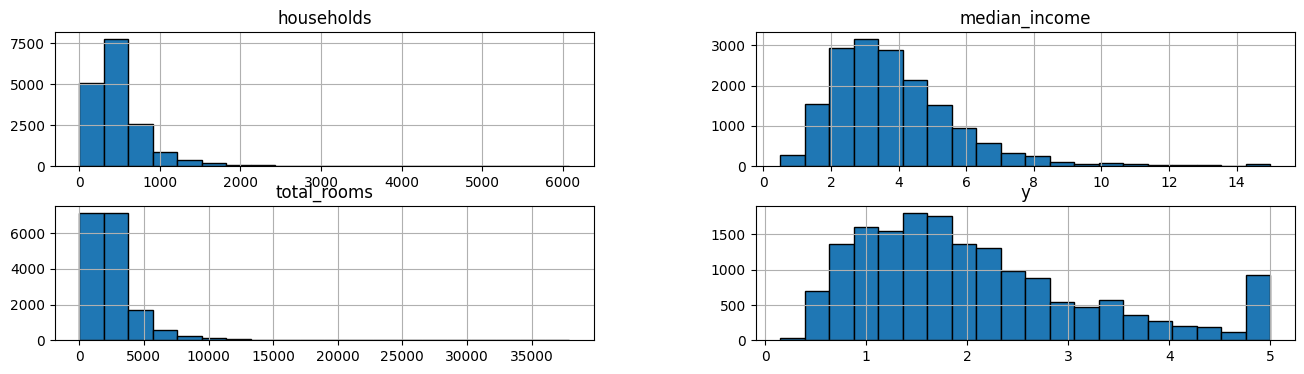

In [11]:
train_data[features].hist(figsize=(16, 4), bins=20, edgecolor="black")
plt.show()

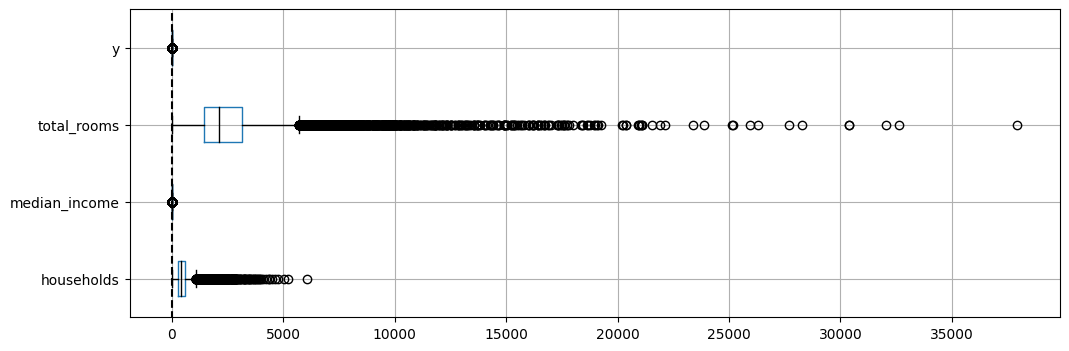

In [12]:
color = {"whiskers": "black", "medians": "black", "caps": "black"}
train_data[features].boxplot(
    figsize=(12, 4),
    vert=False,
    color=color
)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
plt.show()

Data are scaled by standardising them because this method is less sensitive to outliers because it focuses on the mean and standard deviation.  In addition, for training using neural networks, scaling the variables benefits the training time.

**only regressors are normalised**

In [13]:
scaler = StandardScaler()
scaler.fit(train_data[train_data.columns.difference(['longitude','latitude','y',])])
train_data[train_data.columns.difference(['longitude','latitude','y'])] = scaler.transform(train_data[train_data.columns.difference(['longitude','latitude','y'])])

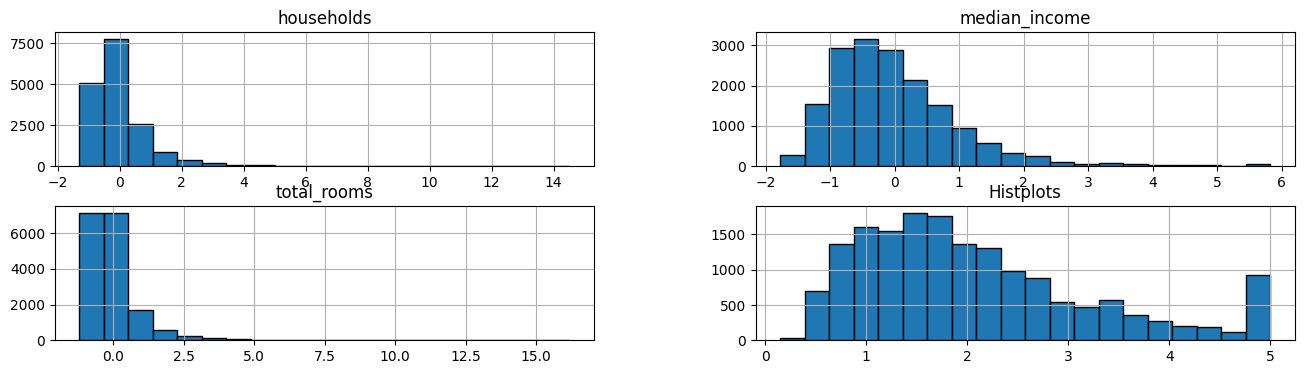

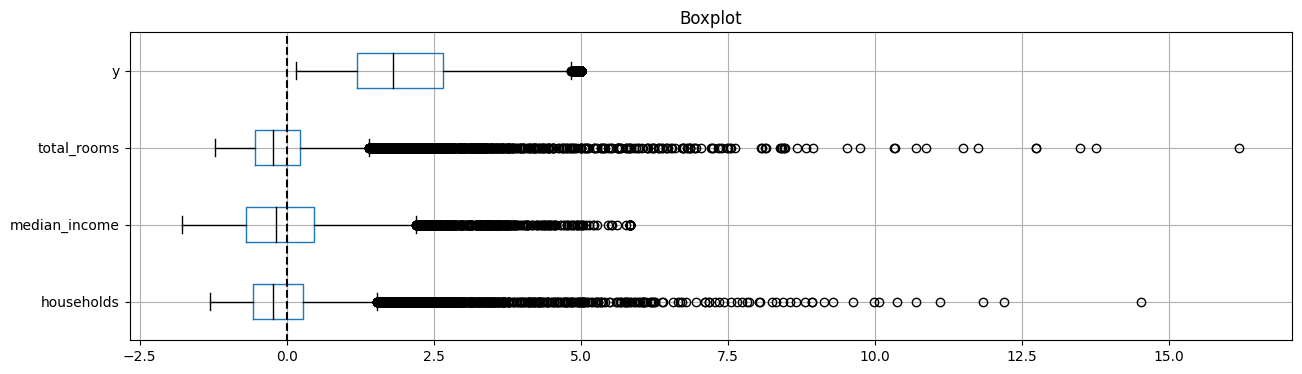

In [14]:
train_data[features].hist(figsize=(16, 4), bins=20, edgecolor="black")
plt.title('Histplots')
plt.show()

color = {"whiskers": "black", "medians": "black", "caps": "black"}
train_data[features].boxplot(
    figsize=(15, 4),
    vert=False,
    color=color
)
plt.axvline(x=0, ymin=-1, ymax=1, color="black", linestyle="--")
plt.title('Boxplot')
plt.show()

## Geographical location

According to the coordinates of each geographical unit in the census data, it can be observed that the median house values of the expensive houses are very close to each other, as are the median house values of the cheapest ones.



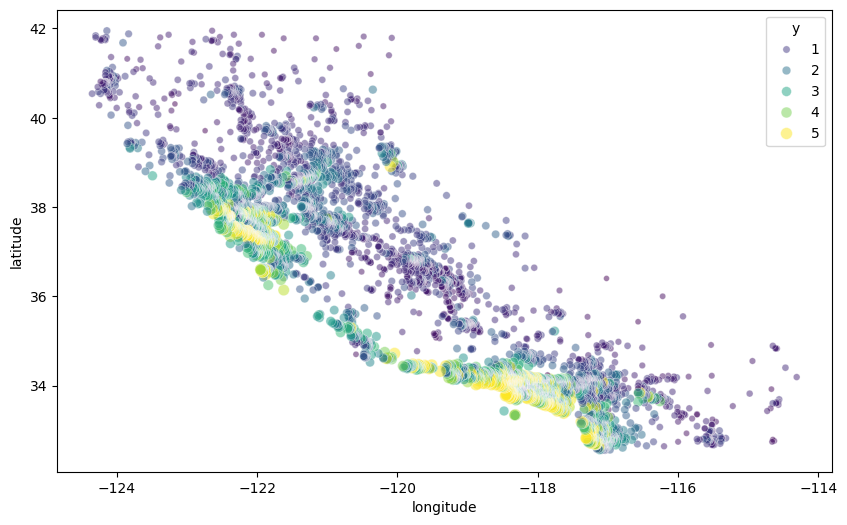

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=train_data,
    x="longitude",
    y="latitude",
    size='y',
    hue='y',
    palette="viridis",
    alpha=0.5,
)
plt.show()

The majority of the groups surveyed (60%) have median house values between \$14,400 and \$209,000 USD.


**Geographic location is a valuable regressor for estimating average house prices**

In [16]:
train_data['y'].value_counts(bins=5, normalize=True).sort_index()*100

y
(0.144, 1.12]    21.700000
(1.12, 2.09]     38.170588
(2.09, 3.06]     21.864706
(3.06, 4.03]      9.794118
(4.03, 5.0]       8.470588
Name: proportion, dtype: float64

coordinates are also scaled to facilitate the training of the dense neural network.

In [17]:
scaler2 = StandardScaler()
train_data[['longitude','latitude']] = scaler2.fit_transform(train_data[['longitude','latitude']])

# Training data

In [18]:
regressors = ['households', 'median_income', 'total_rooms','longitude','latitude']
regressors

['households', 'median_income', 'total_rooms', 'longitude', 'latitude']

In [20]:
regressors_1_1 = ['households', 'median_income','longitude','latitude']
regressors_1_2 = ['total_rooms', 'median_income','longitude','latitude']

In [21]:
X_train = train_data[regressors].values
X_train_1_1 = train_data[regressors_1_1].values
X_train_1_2 = train_data[regressors_1_2].values
y_train = train_data['y'].values

In [22]:
train_data[regressors].head()

,households,median_income,total_rooms,longitude,latitude
0,-0.075998,-1.252543,1.361695,2.619365,-0.671520
1,-0.099404,-1.081483,2.296608,2.539569,-0.573264
2,-0.999252,-1.170105,-0.882462,2.494683,-0.905463
3,-0.715774,-0.362600,-0.524186,2.489696,-0.928857
4,-0.622148,-1.026454,-0.545747,2.489696,-0.961609


# Dense neural network training

In [23]:
input_shape = X_train.shape[1]
input_shape

5

In [24]:
print(f'Training data shape: {X_train.shape}')

Training data shape: (17000, 5)


In [26]:
initializer = keras.initializers.GlorotUniform(seed=1234)

model = Sequential(name='MedianHouseValues')
model.add(Dense(1024, activation='elu', input_shape=(input_shape, ), kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(512, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(128, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(128, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(8, activation='elu', kernel_initializer=initializer))
model.add(BatchNormalization())
model.add(Dropout(0.35))
model.add(Dense(1, activation='linear', kernel_initializer=initializer))
model.summary()

reduce_lr = tf.keras.callbacks.LearningRateScheduler(
    lambda x: 0.001*0.9**x
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True
)

model.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(0.001),
            metrics=['mean_squared_error'])

with tf.device('/device:GPU:0'):
  history = model.fit(
      X_train,
      y_train,
      validation_split=0.2,
      verbose=1,
      epochs=1000,
      callbacks=[early_stop],
      batch_size=128
  )


Model: "MedianHouseValues"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1024)              6144      
                                                                 
 batch_normalization_11 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_13 (Dense)            (None, 512)               524800    
                                                                 
 batch_normalization_12 (Ba  (None, 512)               2048      
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 512)         

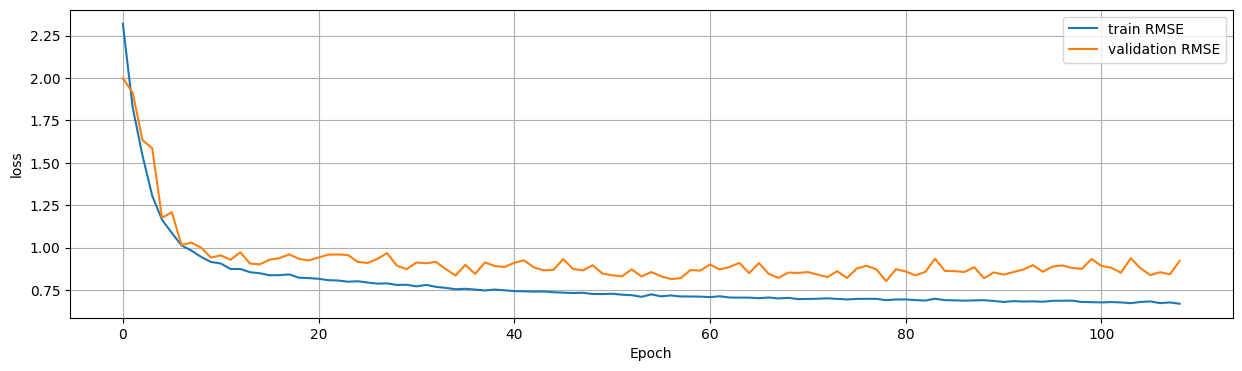

In [27]:
def plot_loss(history):
  plt.figure(figsize=(15,4))
  plt.plot(np.array(history.history['mean_squared_error'])**0.5, label='train RMSE')
  plt.plot(np.array(history.history['val_mean_squared_error'])**0.5, label='validation RMSE')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)

plot_loss(history)


# Multi input MLP

In [28]:
input_shape_1_1 = X_train_1_1.shape[1]
input_shape_1_2 = X_train_1_2.shape[1]

In [165]:
# define two sets of inputs
input_1_1 = tf.keras.Input(shape=(input_shape_1_1,))
input_1_2 = tf.keras.Input(shape=(input_shape_1_2,))

# the first branch operates on the first input
x_1_1= Dense(128, activation="elu", kernel_initializer=initializer)(input_1_1)
x_1_1= BatchNormalization()(x_1_1)
x_1_1= Dropout(0.25)(x_1_1)
x_1_1= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_1)
x_1_1= BatchNormalization()(x_1_1)
x_1_1= Dropout(0.25)(x_1_1)
x_1_1= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_1)
x_1_1= BatchNormalization()(x_1_1)
x_1_1= Dropout(0.25)(x_1_1)
x_1_1= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_1)
x_1_1= BatchNormalization()(x_1_1)
x_1_1= Dropout(0.25)(x_1_1)
x_1_1= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_1)
x_1_1= BatchNormalization()(x_1_1)
x_1_1= Dropout(0.25)(x_1_1)
x_1_1= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_1)
x_1_1 = tf.keras.Model(inputs=input_1_1, outputs=x_1_1)

# the second branch opreates on the second input
x_1_2 = Dense(128, activation="elu", kernel_initializer=initializer)(input_1_2)
x_1_2= BatchNormalization()(x_1_2)
x_1_2= Dropout(0.25)(x_1_2)
x_1_2 = Dense(128, activation="elu", kernel_initializer=initializer)(x_1_2)
x_1_2= BatchNormalization()(x_1_2)
x_1_2= Dropout(0.25)(x_1_2)
x_1_2 = Dense(128, activation="elu", kernel_initializer=initializer)(x_1_2)
x_1_2= BatchNormalization()(x_1_2)
x_1_2= Dropout(0.25)(x_1_2)
x_1_2 = Dense(128, activation="elu", kernel_initializer=initializer)(x_1_2)
x_1_2= BatchNormalization()(x_1_2)
x_1_2= Dropout(0.25)(x_1_2)
x_1_2 = Dense(128, activation="elu", kernel_initializer=initializer)(x_1_2)
x_1_2= BatchNormalization()(x_1_2)
x_1_2= Dropout(0.25)(x_1_2)
x_1_2 = Dense(128, activation="elu", kernel_initializer=initializer)(x_1_2)
x_1_2= BatchNormalization()(x_1_2)
x_1_2= Dropout(0.25)(x_1_2)
x_1_2 = tf.keras.Model(inputs=input_1_2 , outputs=x_1_2)

# combine the output of the two branches
combined = concatenate([x_1_1.output, x_1_2.output])

# apply a FC layer and then a regression prediction on the
# combined outputs
x_1_3= Dense(512, activation="elu", kernel_initializer=initializer)(combined)
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3= Dense(512, activation="elu", kernel_initializer=initializer)(x_1_3 )
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_3 )
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3= Dense(128, activation="elu", kernel_initializer=initializer)(x_1_3 )
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3= Dense(32, activation="elu", kernel_initializer=initializer)(x_1_3 )
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3= Dense(16, activation="elu", kernel_initializer=initializer)(x_1_3 )
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3= Dense(8, activation="elu", kernel_initializer=initializer)(x_1_3 )
x_1_3= BatchNormalization()(x_1_3)
x_1_3= Dropout(0.25)(x_1_3)
x_1_3 = Dense(1, activation="linear", kernel_initializer=initializer)(x_1_3 )

# our model will accept the inputs of the two branches and
# then output a single value
model_2 = tf.keras.Model(inputs=[x_1_1.input, x_1_2.input], outputs=x_1_3)
model_2.summary()

model_2.compile(loss='mean_squared_error',
            optimizer=tf.keras.optimizers.Adam(0.001),
            metrics=['mean_squared_error'])

with tf.device('/device:GPU:0'):
  history = model_2.fit(
      [X_train_1_1, X_train_1_2],
      y_train,
      validation_split=0.2,
      verbose=1,
      epochs=1000,
      callbacks=[early_stop],
      batch_size=128
  )


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 dense_170 (Dense)           (None, 128)                  640       ['input_16[0][0]']            
                                                                                                  
 input_15 (InputLayer)       [(None, 4)]                  0         []                            
                                                                                                  
 batch_normalization_153 (B  (None, 128)                  512       ['dense_170[0][0]']           
 atchNormalization)                                                                        

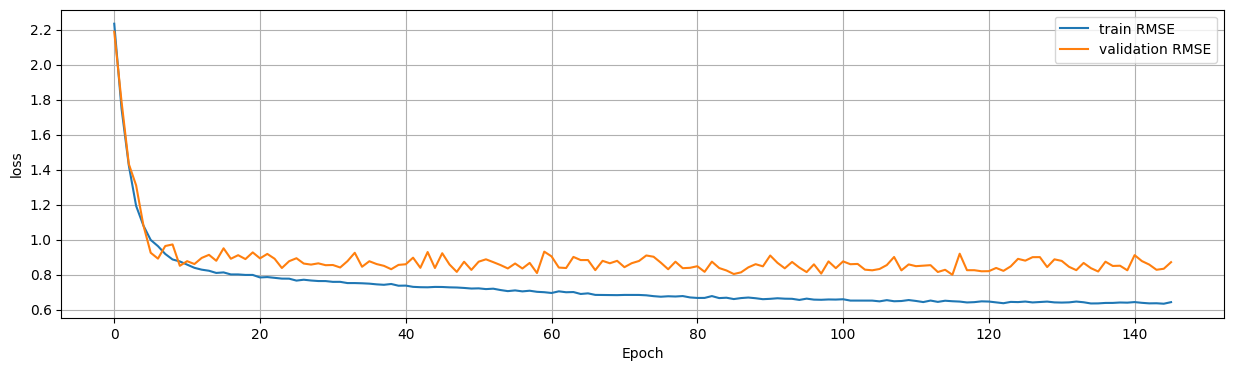

In [166]:
def plot_loss(history):
  plt.figure(figsize=(15,4))
  plt.plot(np.array(history.history['mean_squared_error'])**0.5, label='train RMSE')
  plt.plot(np.array(history.history['val_mean_squared_error'])**0.5, label='validation RMSE')
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid(True)

plot_loss(history)

# Test data

In [167]:
test_data = pd.read_csv('/content/sample_data/california_housing_test.csv')

In [168]:
test_data.rename(columns={'median_house_value':'y'},inplace=True)

In [169]:
test_data['y'] = test_data['y']/100000

In [170]:
test_data[test_data.columns.difference(['longitude','latitude','y'])] = scaler.transform(test_data[test_data.columns.difference(['longitude','latitude','y'])])

In [171]:
test_data[['longitude','latitude']] = scaler2.transform(test_data[['longitude','latitude']])

In [172]:
X_test = test_data[regressors].values
X_test_1_1 = test_data[regressors_1_1].values
X_test_1_2 = test_data[regressors_1_2].values
y_test = test_data['y'].values

In [173]:
predictions   = model.predict(X_test)
predictions_2 = model_2.predict([X_test_1_1, X_test_1_2])

94/94 [==============================] - 1s 4ms/step


# Regression model evaluation metrics

The independent variables explain approximately 64% of the variance of the dependent variable


In [174]:
print(f'Test data shape {len(y_test)}')

Test data shape 3000


In [175]:

results = {
    'r2':[],
    'mae':[],
    'rmse':[],
    'mape':[],
    'asertivity':[]
}


y_real    = y_test.squeeze()
y_predict = predictions.squeeze()

r2 = r2_score(
    y_true = y_real,
    y_pred = y_predict,
)

mae = mean_absolute_error(
    y_true = y_real,
    y_pred = y_predict,
)

mse = mean_squared_error(
    y_true = y_real,
    y_pred = y_predict,
)

mape = mean_absolute_percentage_error(
    y_true = y_real,
    y_pred = y_predict,
)

results['r2'].append(r2)
results['mae'].append(mae)
results['rmse'].append(mse**0.5)
results['mape'].append(mape)
results['asertivity'].append(1-mape)


results = pd.DataFrame(results)
print('Model_1')
results

results_df = pd.DataFrame({'y':y_real, 'yhat':y_predict})

Model_1


In [176]:

results2 = {
    'r2':[],
    'mae':[],
    'rmse':[],
    'mape':[],
    'asertivity':[]
}


y_real    = y_test.squeeze()
y_predict = predictions_2.squeeze()

r2 = r2_score(
    y_true = y_real,
    y_pred = y_predict,
)

mae = mean_absolute_error(
    y_true = y_real,
    y_pred = y_predict,
)

mse = mean_squared_error(
    y_true = y_real,
    y_pred = y_predict,
)

mape = mean_absolute_percentage_error(
    y_true = y_real,
    y_pred = y_predict,
)

results2['r2'].append(r2)
results2['mae'].append(mae)
results2['rmse'].append(mse**0.5)
results2['mape'].append(mape)
results2['asertivity'].append(1-mape)


results2 = pd.DataFrame(results2)
print('Model_2')
results2

results_df_2 = pd.DataFrame({'y':y_real, 'yhat':y_predict})

Model_2


In [177]:
results

,r2,mae,rmse,mape,asertivity
0,0.647629,0.464971,0.671376,0.258278,0.741722


In [178]:
results2

,r2,mae,rmse,mape,asertivity
0,0.705107,0.422318,0.614183,0.230399,0.769601


# Random sample of 100 predictions

In [184]:
rand_idx = np.random.randint(0, len(results_df),100)
idx = [i for i in range(10)]

fig = go.Figure()
fig.add_scatter(x=idx, y=results_df.loc[rand_idx].y, mode="lines", name="y")
fig.add_scatter(x=idx, y=results_df.loc[rand_idx].yhat, mode="lines", name="yhat", line=dict(width=3, dash="dash"))
fig.update_layout(title=f"Model 1: Real Median house values vs Median house values prediction")
fig.show()

fig = go.Figure()
fig.add_scatter(x=idx, y=results_df_2.loc[rand_idx].y, mode="lines", name="y")
fig.add_scatter(x=idx, y=results_df_2.loc[rand_idx].yhat, mode="lines", name="yhat", line=dict(width=3, dash="dash"))
fig.update_layout(title=f"Model 2: Real Median house values vs Median house values prediction")
fig.show()